<a href="https://colab.research.google.com/github/Latheeshshetty/stethoscope-system-for-heart-disease-prediction/blob/main/stetho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the required libraries**

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import librosa
import csv

In [ ]:
SAMPLE_RATE = 16000
MAX_SOUND_CLIP_DURATION=12

## reading the set-a csv file

In [ ]:
set_a=pd.read_csv('/content/drive/MyDrive/set_aa.csv')

In [ ]:
set_a

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
171,a,set_a/__201108222241.wav,NaN,NaN
172,a,set_a/__201108222244.wav,NaN,NaN
173,a,set_a/__201108222247.wav,NaN,NaN
174,a,set_a/__201108222254.wav,NaN,NaN


## reading the set-b csv file

In [ ]:
set_b=pd.read_csv('/content/drive/MyDrive/set_bb.csv')

In [ ]:
set_b

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


In [ ]:
frames = [set_a, set_b]
data_ab=pd.concat(frames)

In [ ]:
print("Number of training examples=", data_ab.shape[0], "  Number of classes=", len(data_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


##  Feature extraction

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

    # get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ",file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


In [ ]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


## Loading the dataset-a and keep them for testing purpose

In [ ]:
import os, fnmatch

A_folder='/content/drive/MyDrive/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  /content/drive/MyDrive/set_a/artifact__201105061143.wav
fixing audio lenght : artifact__201105061143.wav
load file  /content/drive/MyDrive/set_a/artifact__201106010602.wav
fixing audio lenght : artifact__201106010602.wav
load file  /content/drive/MyDrive/set_a/artifact__201105041959.wav
fixing audio lenght : artifact__201105041959.wav
load file  /content/drive/MyDrive/set_a/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  /content/drive/MyDrive/set_a/artifact__201012172012.wav
fixing audio lenght : artifact__201012172012.wav
load file  /content/drive/MyDrive/set_a/artifact__201105190800.wav
fixing audio lenght : artifact__201105190800.wav
load file  /content/drive/MyDrive/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  /content/drive/MyDrive/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  /content/drive/MyDrive/set_a/artifact__201105051017.wav
fixin

## Loading the dataset-b and keep them for testing purpose

In [ ]:
%%time 
B_folder='/content/drive/MyDrive/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir('/content/drive/MyDrive/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  /content/drive/MyDrive/set_b/normal__134_1306428161797_D.wav
fixing audio lenght : normal__134_1306428161797_D.wav
load file  /content/drive/MyDrive/set_b/normal__168_1307970069434_A2.wav
fixing audio lenght : normal__168_1307970069434_A2.wav
load file  /content/drive/MyDrive/set_b/normal__140_1306519735121_A.wav
fixing audio lenght : normal__140_1306519735121_A.wav
load file  /content/drive/MyDrive/set_b/normal_noisynormal_107_1305654946865_A.wav
fixing audio lenght : normal_noisynormal_107_1305654946865_A.wav
load file  /content/drive/MyDrive/set_b/normal__128_1306344005749_B.wav
fixing audio lenght : normal__128_1306344005749_B.wav
load file  /content/drive/MyDrive/set_b/normal__174_1307987737137_B.wav
fixing audio lenght : normal__174_1307987737137_B.wav
load file  /content/drive/MyDrive/set_b/normal__151_1306779785624_D.wav
fixing audio lenght : normal__151_1306779785624_D.wav
load file  /content/drive/MyDrive/set_b/normal__106_1306776721273_B1.wav
fixing audio lenght :

## combine set-a and set-b datasets

In [ ]:
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [ ]:
x_data=np.squeeze(x_data)
test_x=np.squeeze(test_x)

In [ ]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed, shuffle=True)

## Logistic Regression algorithm

In [ ]:
from sklearn.linear_model import LogisticRegression
logi_reg=LogisticRegression()
logi_reg.fit(x_train,y_train)
ypred_logi=logi_reg.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
acc_logi=accuracy_score(y_test,ypred_logi)
print(acc_logi*100)

72.64957264957265


In [ ]:
cm_logi=confusion_matrix(y_test,ypred_logi)

In [ ]:
print(cm_logi)

[[10  1  0]
 [ 0  8 17]
 [ 1 13 67]]


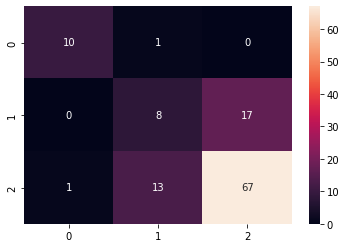

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
sb.heatmap(cm_logi,annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

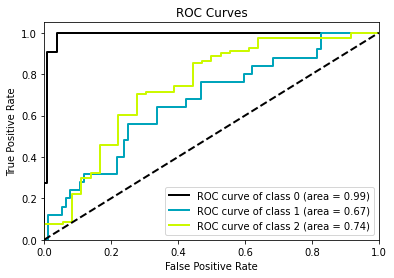

<Figure size 432x288 with 0 Axes>

In [ ]:
import scikitplot as skplt
prob_logi=logi_reg.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_logi,curves=("each_class"))
plt.figure()

## Random forest machine algorithm

In [ ]:
from sklearn.ensemble import RandomForestClassifier
mod_RF=RandomForestClassifier()
mod_RF.fit(x_train,y_train)
pred_RF=mod_RF.predict(x_test)

In [ ]:
acc_RF=accuracy_score(y_test,pred_RF)
print(acc_RF*100)

74.35897435897436


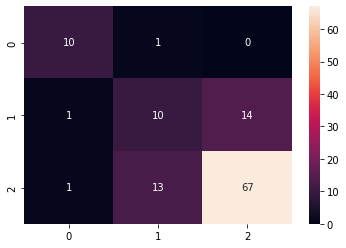

In [ ]:
cm_RF=confusion_matrix(y_test,pred_RF)
sb.heatmap(cm_RF,annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

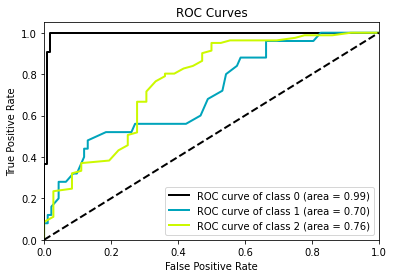

<Figure size 432x288 with 0 Axes>

In [ ]:
prob_RF=mod_RF.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_RF,curves=("each_class"))
plt.figure()
#cm1=skplt.metrics.confusion_matrix(y_test,pred_RF)

## AdaBoost Classifier algorithm

68.37606837606837


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

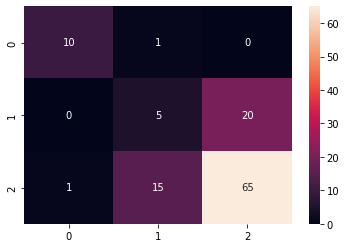

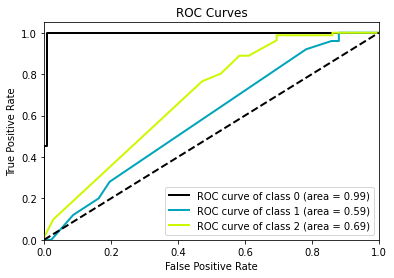

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
mod_ada=AdaBoostClassifier()
mod_ada.fit(x_train,y_train)
pred_ada=mod_ada.predict(x_test)
acc_ada=accuracy_score(y_test,pred_ada)
print(acc_ada*100)
cm_ada=confusion_matrix(y_test,pred_ada)
sb.heatmap(cm_ada,annot=True)
prob_ada=mod_ada.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_ada,curves=("each_class"))
plt.figure()

## Suport Vector machine algorithm

70.08547008547008


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

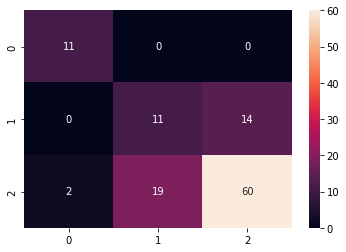

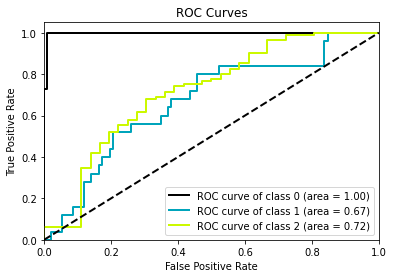

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.svm import SVC
mod_svc=SVC(kernel='linear',probability = True)
mod_svc.fit(x_train,y_train)
pred_svc=mod_svc.predict(x_test)
acc_svc=accuracy_score(y_test,pred_svc)
print(acc_svc*100)
cm_svc=confusion_matrix(y_test,pred_svc)
sb.heatmap(cm_svc,annot=True)
prob_svc=mod_svc.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_test,prob_svc,curves=("each_class"))
plt.figure()

In [ ]:
ACC=pd.DataFrame({'Algorithm':['Logistic Regression', 'Random Forest','Adaboost','SVM'],'Accuracy':[acc_logi*100,acc_RF*100,acc_ada*100,acc_svc*100]},columns=['Algorithm','Accuracy'])


## Accuracy of each algorthm

In [ ]:
ACC.head()

,Algorithm,Accuracy
0,Logistic Regression,72.649573
1,Random Forest,74.358974
2,Adaboost,40.170940
3,SVM,70.085470
